# Práctica 3 Aplicaciones de análisis
## Series temporales

Vamos a cargar los datos obtenidos tras el primer notebook de análisis, y a aplicarle algunos modelos con distinto horizonte y ver como son capaces de predecir los datos de la serie, y compararlos con los reales.

In [1]:
# imports necesarios
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import mean_squared_error

import statsmodels.tsa.seasonal as tsa

from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.stattools import acf
import pyflux as pf
import statsmodels.tsa.api as smt

from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings

In [2]:
# cargamos los datos generados en el notebook de análisis
df_eolica_stacionary = pd.read_csv('series_stacionary.csv', sep=',', header=0, parse_dates=[0], dtype=np.float64,\
                        dayfirst=True, index_col=0)

potInstal = 17560
# Para tener valores más manejables dividimos los datos entre la potencia instalada del parque
df_eolica_stacionary = df_eolica_stacionary/potInstal

print("Columnas:\n", list(df_eolica_stacionary.columns))

Columnas:
 ['Wind Energy']


La serie temporal dada se dividirá en un conjunto de entrenamiento (años 2016 y 2017) y un conjunto de test (año 2018).

In [3]:
# Definimos la partición de train y test
series_train = df_eolica_stacionary['2016':'2017']
series_test = df_eolica_stacionary['2018']

In [4]:
series_train.describe()

,Wind Energy
count,719.000000
mean,0.006880
std,5.013499
min,-18.342683
25%,-1.988804
50%,0.426924
75%,2.654971
max,16.375174


In [5]:
series_test.describe()

,Wind Energy
count,365.000000
mean,-0.002165
std,5.650685
min,-18.805856
25%,-2.539528
50%,0.114929
75%,3.104957
max,18.449502


## Modelo AR

Primero vamos a ver un modelo autoregresivo **AR(p)** de orden p, que consiste en una regresión lineal de los retrasos hasta tiempo t-p. Statsmodels presenta un modelo AR con el que entrenar y predecir.

In [6]:
model_ar = AR(series_train, freq = 'D')
model_fit_ar = model_ar.fit()

y_ar = model_fit_ar.predict(start = '2018-01-01', end = '2018-12-31')

print(model_fit_ar.params)
print('\n')
print('mean_squared_error: ', mean_squared_error(series_test['2018-01-01':'2018-12-31'], y_ar))

const              0.030267
L1.Wind Energy    -1.162595
L2.Wind Energy    -1.470365
L3.Wind Energy    -1.621494
L4.Wind Energy    -1.704270
L5.Wind Energy    -1.718282
L6.Wind Energy    -1.734800
L7.Wind Energy    -1.712927
L8.Wind Energy    -1.648913
L9.Wind Energy    -1.560581
L10.Wind Energy   -1.421455
L11.Wind Energy   -1.323170
L12.Wind Energy   -1.227135
L13.Wind Energy   -1.099501
L14.Wind Energy   -0.954561
L15.Wind Energy   -0.697429
L16.Wind Energy   -0.526009
L17.Wind Energy   -0.379939
L18.Wind Energy   -0.253965
L19.Wind Energy   -0.124515
L20.Wind Energy   -0.102408
dtype: float64


mean_squared_error:  31.719903291736742


In [7]:
# variables a usar con los horizontes
beginning='2016-01-01'
start='2018-01-01'
end='2018-12-31'

model_ar = AR(series_train, freq='D')
model_fit_ar = model_ar.fit()
y_hor = model_fit_ar.predict(start,start)
series_trainD=df_eolica_stacionary[beginning:start]

# pruebas con horizontes
horizon=0

for date in pd.date_range(start='2018-01-02', end='2018-06-01', freq='D', closed=None):
    model_ar = AR(series_trainD,freq='D')
    model_fit_ar = model_ar.fit()
    pred = model_fit_ar.predict(date,date+horizon)
    y_hor = y_hor.append(pred.last('1MS'))
    series_trainD = df_eolica_stacionary[beginning:date]
    
if horizon > 0:
    y_r = y_hor[:-horizon]
else:
    y_r = y_hor
    

model_ar_2 = AR(series_train, freq='D')
model_fit_ar_2 = model_ar_2.fit()
y_hor_2=model_fit_ar_2.predict(start,start)

for date in pd.date_range(start='2018-01-02', end='2018-12-31', freq='D', closed=None):
    model_ar_2 = AR(series_trainD,freq='D')
    model_fit_ar_2 = model_ar_2.fit()
    pred = model_fit_ar_2.predict(date,date+horizon)
    y_hor_2 = y_hor_2.append(pred.last('1MS'))
    series_trainD = df_eolica_stacionary[beginning:date]
    
if horizon > 0:
    y_r_2 = y_hor_2[:-horizon]
else:
    y_r_2 = y_hor_2

<Figure size 432x288 with 0 Axes>

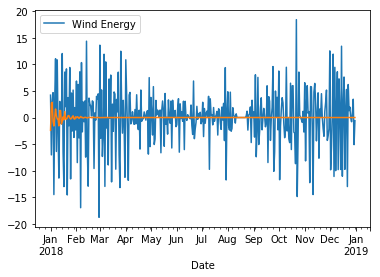

<Figure size 432x288 with 0 Axes>

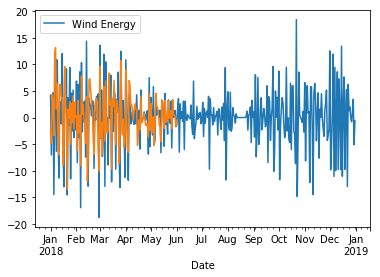

<Figure size 432x288 with 0 Axes>

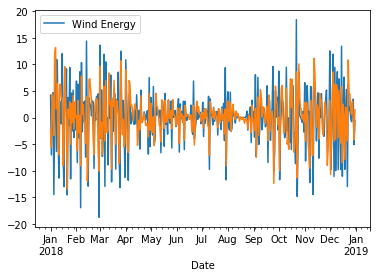

In [8]:
# pintamos tres gráficas, tanto de los valores de test como los valores predecidos por los modelos
plt.figure();series_test.plot();y_ar.plot();
plt.figure();series_test.plot();y_hor.plot();
plt.figure();series_test.plot();y_hor_2.plot();

In [9]:
# ver valor error RMSE
mse_y = mean_squared_error(series_test, y_ar)
mse_yr = mean_squared_error(series_test['2018-01-01':'2018-06-01'], y_r)
mse_yr_2 = mean_squared_error(series_test, y_r_2)

print(mse_y); 
print(mse_yr);
print(mse_yr_2);

31.719903291736742
15.59796699680534
12.310996071897664


Los valores más bajos de RMSE indican un mejor ajuste. RMSE es una buena medida de la precisión con que el modelo predice la respuesta, y es el criterio más importante para ajustar si el propósito principal del modelo es la predicción.

Se aprecia como el error RMSE baja con el horizonte de todo el año 2018 para predecir y validar.

## Modelo ARMA

Probemos también un modelo **ARMA(p,q)** que combina un modelo autorregresivo y de medias móviles.

Independientemente del modelo que utilicemos, siempre debemos entrenarlo con los **datos de train** utilizando primero la llamada al constructor del modelo en cuestión (en este ejemplo **ARMA**). A este modelo hay que pasarle además de los datos, el valor de los hiperparámetros.

Una vez fijado el modelo lo entrenamos con la función **fit()**. Con ella se estimarán los valores de los parámetros. Estos valores se pueden ver o bien con **model_fit.params** o bien con la función **model_fit.summary()**.

In [6]:
# función para pintar gráfica
def pintar_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-', label="actual")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)
    plt.legend();

Iteración  1 

const                0.003759
ar.L1.Wind Energy   -0.433932
dtype: float64
                              ARMA Model Results                              
Dep. Variable:            Wind Energy   No. Observations:                  719
Model:                     ARMA(1, 0)   Log Likelihood               -2104.574
Method:                       css-mle   S.D. of innovations              4.518
Date:                Sun, 21 Apr 2019   AIC                           4215.147
Time:                        16:52:32   BIC                           4228.881
Sample:                    01-13-2016   HQIC                          4220.450
                         - 12-31-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0038      0.118      0.032      0.974      -0.227       0.234
ar.L1.Wind Energy   

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

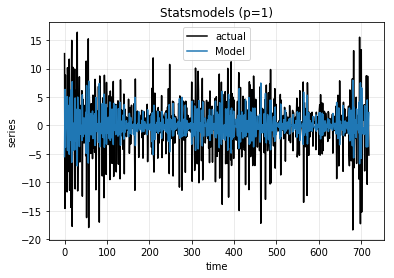



Iteración  2 

const                0.005946
ar.L1.Wind Energy   -0.620071
ar.L2.Wind Energy   -0.438066
dtype: float64
                              ARMA Model Results                              
Dep. Variable:            Wind Energy   No. Observations:                  719
Model:                     ARMA(2, 0)   Log Likelihood               -2029.115
Method:                       css-mle   S.D. of innovations              4.066
Date:                Sun, 21 Apr 2019   AIC                           4066.230
Time:                        16:52:32   BIC                           4084.542
Sample:                    01-13-2016   HQIC                          4073.300
                         - 12-31-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0059      0.074      0.081      0.936      -0.139 

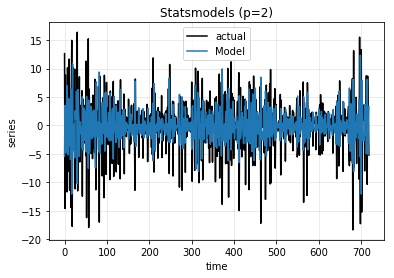



Iteración  3 

const                0.005781
ar.L1.Wind Energy   -0.768803
ar.L2.Wind Energy   -0.646131
ar.L3.Wind Energy   -0.341330
dtype: float64
                              ARMA Model Results                              
Dep. Variable:            Wind Energy   No. Observations:                  719
Model:                     ARMA(3, 0)   Log Likelihood               -1985.271
Method:                       css-mle   S.D. of innovations              3.825
Date:                Sun, 21 Apr 2019   AIC                           3980.541
Time:                        16:52:32   BIC                           4003.430
Sample:                    01-13-2016   HQIC                          3989.378
                         - 12-31-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0058      0.052     

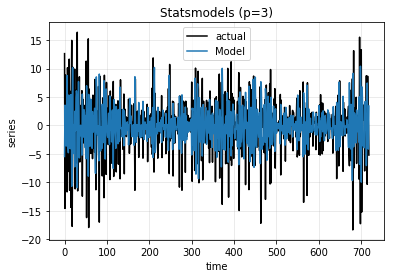



Iteración  4 

const                0.004381
ar.L1.Wind Energy   -0.868647
ar.L2.Wind Energy   -0.836755
ar.L3.Wind Energy   -0.566420
ar.L4.Wind Energy   -0.296670
dtype: float64
                              ARMA Model Results                              
Dep. Variable:            Wind Energy   No. Observations:                  719
Model:                     ARMA(4, 0)   Log Likelihood               -1952.866
Method:                       css-mle   S.D. of innovations              3.655
Date:                Sun, 21 Apr 2019   AIC                           3917.732
Time:                        16:52:33   BIC                           3945.200
Sample:                    01-13-2016   HQIC                          3928.337
                         - 12-31-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const         

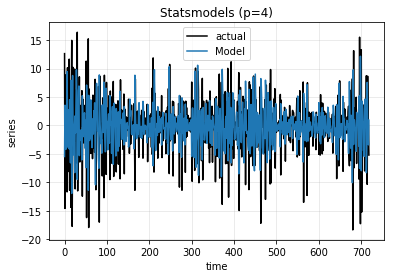



Iteración  5 

const                0.003688
ar.L1.Wind Energy   -0.937073
ar.L2.Wind Energy   -0.966504
ar.L3.Wind Energy   -0.759381
ar.L4.Wind Energy   -0.495446
ar.L5.Wind Energy   -0.231869
dtype: float64
                              ARMA Model Results                              
Dep. Variable:            Wind Energy   No. Observations:                  719
Model:                     ARMA(5, 0)   Log Likelihood               -1933.440
Method:                       css-mle   S.D. of innovations              3.557
Date:                Sun, 21 Apr 2019   AIC                           3880.881
Time:                        16:52:33   BIC                           3912.926
Sample:                    01-13-2016   HQIC                          3893.253
                         - 12-31-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

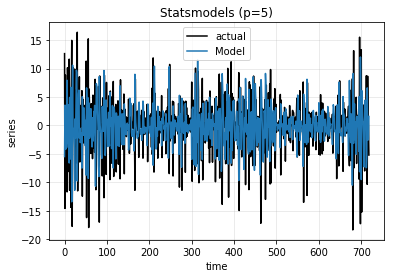

In [11]:
# componente de time
time = np.arange(719)

# pintar con diferentes valores de p de 1 a 5, iterando con bucle for para ver con cada uno los parámetros y pintar
for i in range(1,6):
    print('Iteración ', i, '\n')
    model_arma = ARMA(series_train, (i,0), freq='D').fit()
    pintar_plot(time, series_train, title="Statsmodels (p={})".format(i))
    plt.plot(time, model_arma.predict(start=1, end=719), label="Model")
    plt.legend()
    print(model_arma.params)
    print(model_arma.summary())
    plt.show()
    print('\n');

A medida que aumentamos el valor de P disminuye el valor de la métrica AIC, así que nos quedamos con el último modelo con el parámetro p=5.

Para analizar el modelo también podemos observar los residuos

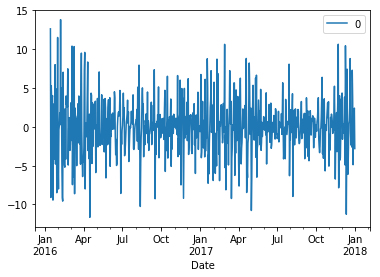

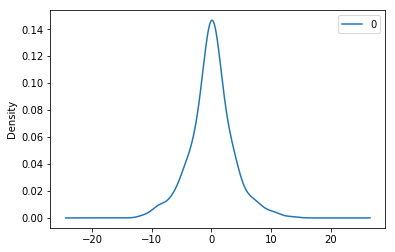

                0
count  719.000000
mean     0.013358
std      3.582953
min    -11.663952
25%     -1.755423
50%      0.055813
75%      1.781696
max     13.799111


In [12]:
residuals = pd.DataFrame(model_arma.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

La primera opción de predicción consiste en predecir todo el intervalo de test al horizonte "que le toque" a cada dato. Esto es sencillo y basta con especificar a **predict()** el principio y fin de este intervalo.

In [13]:
y_arma = model_arma.predict(start='2018-01-01', end='2018-12-31')

La segunda opción es hacer predicciones a un determinado horizonte, de forma que todos los puntos a predecir hayan visto previamente la misma cantidad de información.

In [14]:
beginning='2016-01-01'
start='2018-01-01'
end='2018-12-31'

model_arma = ARMA(series_train, order=(5,0), freq='D')
model_fit_arma = model_arma.fit()
y_hor = model_fit_arma.predict(start,start)
series_trainD = df_eolica_stacionary[beginning:start]

horizon = 0

for date in pd.date_range(start='2018-01-02', end='2018-06-01', freq='D', closed=None):
    model_arma = ARMA(series_trainD, order=(5,0),freq='D')
    model_fit_arma = model_arma.fit()
    pred = model_fit_arma.predict(date,date+horizon)
    y_hor = y_hor.append(pred.last('1MS'))
    series_trainD = df_eolica_stacionary[beginning:date]
    
if horizon > 0:
    y_r = y_hor[:-horizon]
else:
    y_r = y_hor
    

model_arma_2 = ARMA(series_train, order=(5,0), freq='D')
model_fit_arma_2 = model_arma_2.fit()
y_hor_2 = model_fit_arma_2.predict(start,start)

for date in pd.date_range(start='2018-01-02', end='2018-12-31', freq='D', closed=None):
    model_arma_2 = ARMA(series_trainD, order=(5,0),freq='D')
    model_fit_arma_2 = model_arma_2.fit()
    pred = model_fit_arma_2.predict(date,date+horizon)
    y_hor_2 = y_hor_2.append(pred.last('1MS'))
    series_trainD = df_eolica_stacionary[beginning:date]
    
if horizon > 0:
    y_r_2 = y_hor_2[:-horizon]
else:
    y_r_2 = y_hor_2

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

Para conocer la bondad de la predicción realizada, por un lado podemos pintar los datos predichos frente a los reales (estamos ante un escenario de pruebas) y ver si las dos series se parecen.

<Figure size 432x288 with 0 Axes>

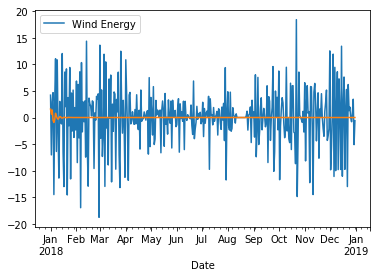

<Figure size 432x288 with 0 Axes>

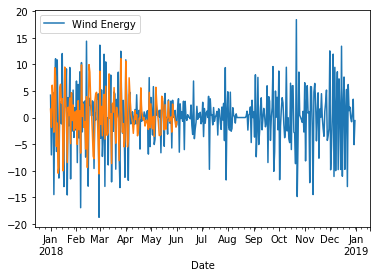

<Figure size 432x288 with 0 Axes>

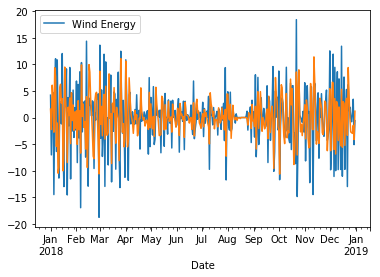

In [15]:
plt.figure();series_test.plot(); y_arma.plot();
plt.figure();series_test.plot(); y_hor.plot()
plt.figure();series_test.plot(); y_hor_2.plot()

Por otro lado, siempre viene bien una medida cuantitativa que nos permita comparar de forma objetiva el resultado con el obtenido con otros modelos. Aunque esta medida dependerá del problema a resolver y de lo objetivos fijados, una de las medidas típicas es el error cuadrático medio.

In [16]:
mse_y = mean_squared_error(series_test, y_arma)
mse_yr = mean_squared_error(series_test['2018-01-01':'2018-06-01'], y_r)
mse_yr_2 = mean_squared_error(series_test, y_r_2)

print(mse_y); 
print(mse_yr);
print(mse_yr_2);

31.73794691279809
18.670325580036774
15.153813500506947


## Modelo ARIMA

El modelo **ARIMA(p, d, q)** de orden (p, d, q), consiste en una regresión lineal de los retrasos hasta tiempo t-p y en los residuos hasta tiempo t-q. Este modelo trabaja con series que presentan una tendencia, por lo que calcula las diferencias sobre los datos pasados y realiza el modelo sobre la serie de diferencias.

Se puede crear un modelo ARIMA utilizando la biblioteca statsmodels de la siguiente manera:

Defina el modelo llamando a ARIMA () y pasando los parámetros p, d y q.
El modelo se prepara en los datos de entrenamiento llamando a la función de ajuste.
Las predicciones se pueden hacer llamando a la función de predicción y especificando el índice del tiempo o los tiempos a predecir.

Primero, ajustamos un modelo ARIMA (5,1,0). Esto establece el valor de retardo en 5 para la autorregresión, usa un orden de diferencia de 1 para hacer que la serie de tiempo sea estacionaria y usa un modelo de promedio móvil de 0.

In [7]:
model_arima = ARIMA(series_train, order=(5,1,0), freq='D')
model_fit_arima = model_arima.fit(disp=0)
print(model_fit_arima.summary())

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

                             ARIMA Model Results                              
Dep. Variable:          D.Wind Energy   No. Observations:                  718
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2099.189
Method:                       css-mle   S.D. of innovations              4.493
Date:                Sun, 21 Apr 2019   AIC                           4212.379
Time:                        17:22:55   BIC                           4244.414
Sample:                    01-14-2016   HQIC                          4224.748
                         - 12-31-2017                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0018      0.026     -0.069      0.945      -0.052       0.048
ar.L1.D.Wind Energy    -1.4455      0.035    -41.239      0.000      -1.514      -1.377
ar.L2.D.Wind Ene

In [8]:
model_arima_2 = ARIMA(series_train, order=(5,2,0), freq='D')
model_fit_arima_2 = model_arima_2.fit(disp=0)
print(model_fit_arima_2.summary())

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

                             ARIMA Model Results                              
Dep. Variable:         D2.Wind Energy   No. Observations:                  717
Model:                 ARIMA(5, 2, 0)   Log Likelihood               -2314.750
Method:                       css-mle   S.D. of innovations              6.088
Date:                Sun, 21 Apr 2019   AIC                           4643.501
Time:                        17:22:56   BIC                           4675.526
Sample:                    01-15-2016   HQIC                          4655.867
                         - 12-31-2017                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0012      0.027      0.045      0.964      -0.051       0.054
ar.L1.D2.Wind Energy    -1.8309      0.034    -54.115      0.000      -1.897      -1.765
ar.L2.D2.Win

Se obtiene peor valor de AIC para los hiperparametros (5,2,0) que con (5,1,0), asi que probamos a variar el valor de p.

Iteración  1 

const                 -0.008093
ar.L1.D.Wind Energy   -0.594288
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:          D.Wind Energy   No. Observations:                  718
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2398.434
Method:                       css-mle   S.D. of innovations              6.829
Date:                Sun, 21 Apr 2019   AIC                           4802.867
Time:                        17:22:57   BIC                           4816.596
Sample:                    01-14-2016   HQIC                          4808.168
                         - 12-31-2017                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0081      0.160     -0.051      0.960      -0.322       0.305
ar.L1.D.Wi

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

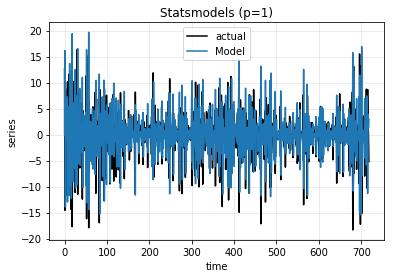



Iteración  2 

const                 -0.004827
ar.L1.D.Wind Energy   -0.902390
ar.L2.D.Wind Energy   -0.527901
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:          D.Wind Energy   No. Observations:                  718
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2283.111
Method:                       css-mle   S.D. of innovations              5.813
Date:                Sun, 21 Apr 2019   AIC                           4574.222
Time:                        17:22:58   BIC                           4592.528
Sample:                    01-14-2016   HQIC                          4581.290
                         - 12-31-2017                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0048      0.089     -0.054      0.957 

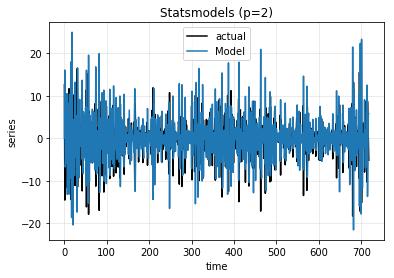



Iteración  3 

const                 -0.001829
ar.L1.D.Wind Energy   -1.134630
ar.L2.D.Wind Energy   -0.924647
ar.L3.D.Wind Energy   -0.443145
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:          D.Wind Energy   No. Observations:                  718
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -2206.193
Method:                       css-mle   S.D. of innovations              5.220
Date:                Sun, 21 Apr 2019   AIC                           4422.387
Time:                        17:22:58   BIC                           4445.269
Sample:                    01-14-2016   HQIC                          4431.222
                         - 12-31-2017                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0018  

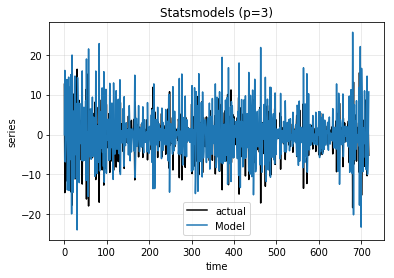



Iteración  4 

const                 -0.001516
ar.L1.D.Wind Energy   -1.308151
ar.L2.D.Wind Energy   -1.290130
ar.L3.D.Wind Energy   -0.892035
ar.L4.D.Wind Energy   -0.399910
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:          D.Wind Energy   No. Observations:                  718
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -2144.947
Method:                       css-mle   S.D. of innovations              4.791
Date:                Sun, 21 Apr 2019   AIC                           4301.894
Time:                        17:22:58   BIC                           4329.352
Sample:                    01-14-2016   HQIC                          4312.496
                         - 12-31-2017                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------


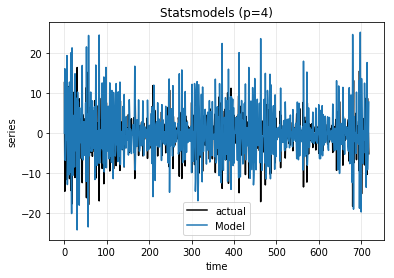



Iteración  5 

const                 -0.001752
ar.L1.D.Wind Energy   -1.445511
ar.L2.D.Wind Energy   -1.597545
ar.L3.D.Wind Energy   -1.338720
ar.L4.D.Wind Energy   -0.853992
ar.L5.D.Wind Energy   -0.349447
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:          D.Wind Energy   No. Observations:                  718
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2099.189
Method:                       css-mle   S.D. of innovations              4.493
Date:                Sun, 21 Apr 2019   AIC                           4212.379
Time:                        17:22:58   BIC                           4244.414
Sample:                    01-14-2016   HQIC                          4224.748
                         - 12-31-2017                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

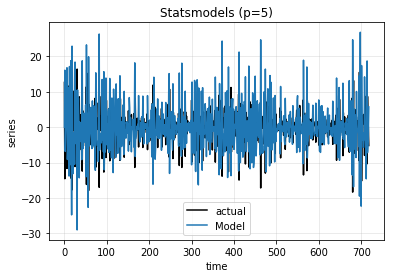



Iteración  6 

const                 -0.001002
ar.L1.D.Wind Energy   -1.549419
ar.L2.D.Wind Energy   -1.846653
ar.L3.D.Wind Energy   -1.730586
ar.L4.D.Wind Energy   -1.322525
ar.L5.D.Wind Energy   -0.774464
ar.L6.D.Wind Energy   -0.295845
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:          D.Wind Energy   No. Observations:                  718
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -2067.412
Method:                       css-mle   S.D. of innovations              4.297
Date:                Sun, 21 Apr 2019   AIC                           4150.823
Time:                        17:22:59   BIC                           4187.435
Sample:                    01-14-2016   HQIC                          4164.959
                         - 12-31-2017                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------

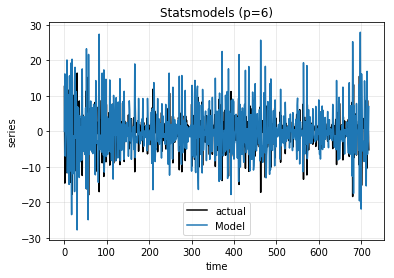



Iteración  7 

const                 -0.000704
ar.L1.D.Wind Energy   -1.617643
ar.L2.D.Wind Energy   -2.028909
ar.L3.D.Wind Energy   -2.039481
ar.L4.D.Wind Energy   -1.728142
ar.L5.D.Wind Energy   -1.208571
ar.L6.D.Wind Energy   -0.660681
ar.L7.D.Wind Energy   -0.237570
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:          D.Wind Energy   No. Observations:                  718
Model:                 ARIMA(7, 1, 0)   Log Likelihood               -2047.225
Method:                       css-mle   S.D. of innovations              4.177
Date:                Sun, 21 Apr 2019   AIC                           4112.450
Time:                        17:23:00   BIC                           4153.638
Sample:                    01-14-2016   HQIC                          4128.353
                         - 12-31-2017                                         
                          coef    std err          z      P>|z|      [0.025     

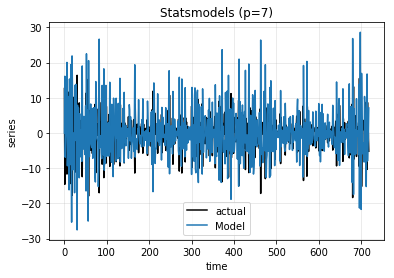



Iteración  8 

const                 -0.000407
ar.L1.D.Wind Energy   -1.671394
ar.L2.D.Wind Energy   -2.178164
ar.L3.D.Wind Energy   -2.314973
ar.L4.D.Wind Energy   -2.119812
ar.L5.D.Wind Energy   -1.672695
ar.L6.D.Wind Energy   -1.123362
ar.L7.D.Wind Energy   -0.607165
ar.L8.D.Wind Energy   -0.230311
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:          D.Wind Energy   No. Observations:                  718
Model:                 ARIMA(8, 1, 0)   Log Likelihood               -2028.296
Method:                       css-mle   S.D. of innovations              4.067
Date:                Sun, 21 Apr 2019   AIC                           4076.592
Time:                        17:23:01   BIC                           4122.356
Sample:                    01-14-2016   HQIC                          4094.262
                         - 12-31-2017                                         
                          coef    std err       

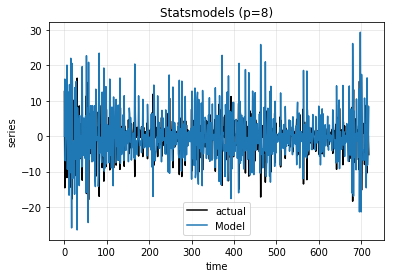



Iteración  9 

const                 -0.000195
ar.L1.D.Wind Energy   -1.727650
ar.L2.D.Wind Energy   -2.327930
ar.L3.D.Wind Energy   -2.591451
ar.L4.D.Wind Energy   -2.533943
ar.L5.D.Wind Energy   -2.196121
ar.L6.D.Wind Energy   -1.696641
ar.L7.D.Wind Energy   -1.148106
ar.L8.D.Wind Energy   -0.645838
ar.L9.D.Wind Energy   -0.250379
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:          D.Wind Energy   No. Observations:                  718
Model:                 ARIMA(9, 1, 0)   Log Likelihood               -2005.808
Method:                       css-mle   S.D. of innovations              3.940
Date:                Sun, 21 Apr 2019   AIC                           4033.616
Time:                        17:23:02   BIC                           4083.957
Sample:                    01-14-2016   HQIC                          4053.053
                         - 12-31-2017                                         
                

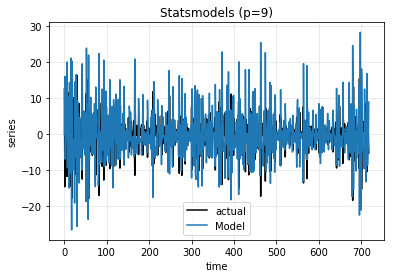

In [9]:
# componente de time
time = np.arange(719)

# pintar con diferentes valores de p de 1 a 9, iterando con bucle for para ver con cada uno los parámetros y pintar
for i in range(1,10):
    print('Iteración ', i, '\n')
    model_arima = ARIMA(series_train, order=(i,1,0), freq='D').fit(disp=0)
    pintar_plot(time, series_train, title="Statsmodels (p={})".format(i))
    plt.plot(time, model_arima.predict(start=1, end=719), label="Model")
    plt.legend()
    print(model_arima.params)
    print(model_arima.summary())
    plt.show()
    print('\n');

El modelo AIC ha reducido, lo cual es bueno. 

Vamos a trazar los residuos para asegurarnos de que no haya patrones (es decir, buscar la media y la varianza constantes).

<Figure size 1584x1080 with 0 Axes>

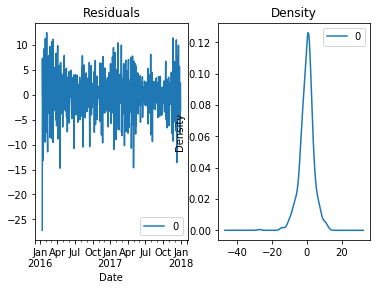

In [10]:
# Plot residual errors
residuals = pd.DataFrame(model_arima.resid)
plt.figure(figsize=(22,15))
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Los errores residuales parecen estar bien con una media y una varianza uniformes cercanas a cero. Vamos a trazar los datos reales contra los valores ajustados utilizando plot_predict ().

In [11]:
y_arima = model_arima.predict(start='2018-01-01', end='2018-12-31')

31.539842392822624


<Figure size 432x288 with 0 Axes>

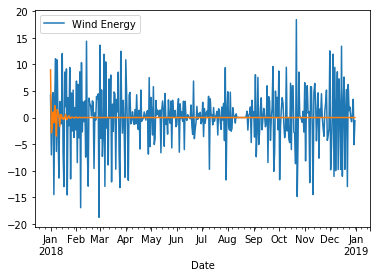

In [20]:
plt.figure();series_test.plot(); y_arima.plot();
mse_y = mean_squared_error(series_test, y_arima); print(mse_y);

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

Test MSE: 19.130




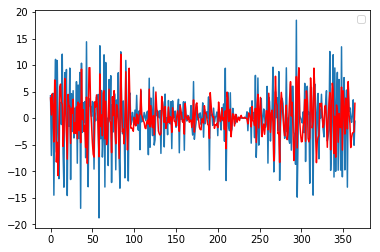

In [27]:
# predicción con los parámetros anteriores, uso de forecast
train = series_train.values
test = series_test.values
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model_arima = ARIMA(history, order=(9,1,0))
    model_fit_arima = model_arima.fit(disp=-1)
    output = model_fit_arima.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
print('\n')

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.legend()
plt.show()

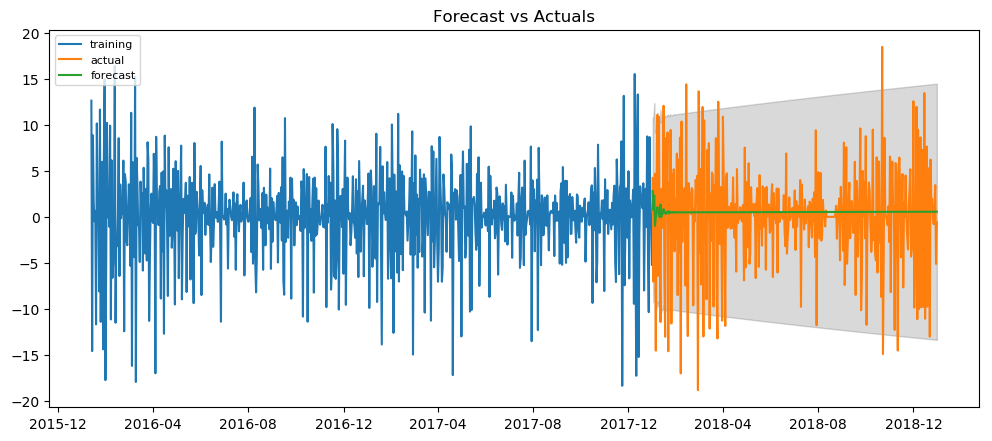

In [30]:
# Pintar forecast
fc, se, conf = model_fit_arima.forecast(365, alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=series_test.index)
lower_series = pd.Series(conf[:, 0], index=series_test.index)
upper_series = pd.Series(conf[:, 1], index=series_test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(series_train, label='training')
plt.plot(series_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Otra forma de aplicar y visualizar modelo ARIMA es usando libreria Pyflux.

In [44]:
# Pyflux importada al inicio del notebook
# pintar con diferentes valores de los parámetros de ARIMA
for i in range(1,10):
    print('Iteración ', i, '\n')
    for j in range(0,6):
        for k in range(0,6):
            model_arima_pf = pf.ARIMA(data=series_train, ar=i, ma=k, integ=j, target='Wind Energy').fit("MLE")
            print(model_arima_pf.aic)
            print('\n');

Iteración  1 

Normal ARIMA(1,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: Wind Energy                         Method: MLE                                       
Start Date: 2016-01-14 00:00:00                         Log Likelihood: -2098.8609                        
End Date: 2017-12-31 00:00:00                           AIC: 4203.7217                                    
Number of observations: 718                             BIC: 4217.4511                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0046    0.168      -0.0274  0.9781   (-0.3338 | 0.3246)       
AR(1)                 

Normal ARIMA(1,1,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Wind Energy             Method: MLE                                       
Start Date: 2016-01-15 00:00:00                         Log Likelihood: -2079.6999                        
End Date: 2017-12-31 00:00:00                           AIC: 4169.3998                                    
Number of observations: 716                             BIC: 4192.2682                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0122     0.0015     8.1774   0.0      (0.0093 | 0.0151)        
AR(1)                                

Normal ARIMA(1,2,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Wind Energy Method: MLE                                       
Start Date: 2016-01-15 00:00:00                         Log Likelihood: -2241.9983                        
End Date: 2017-12-31 00:00:00                           AIC: 4493.9966                                    
Number of observations: 715                             BIC: 4516.8581                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0062    0.013      -0.4775  0.633    (-0.0316 | 0.0192)       
AR(1)                                

Normal ARIMA(1,3,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-14 00:00:00                         Log Likelihood: -2720.508                         
End Date: 2017-12-31 00:00:00                           AIC: 5449.0161                                    
Number of observations: 715                             BIC: 5467.3052                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0076    0.0003     -30.1146 0.0      (-0.0081 | -0.0071)      
AR(1)                                

Normal ARIMA(1,4,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-15 00:00:00                         Log Likelihood: -2921.0272                        
End Date: 2017-12-31 00:00:00                           AIC: 5852.0544                                    
Number of observations: 713                             BIC: 5874.9018                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0327     0.1124     0.2908   0.7712   (-0.1877 | 0.2531)       
AR(1)                                

Normal ARIMA(1,5,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-15 00:00:00                         Log Likelihood: -3339.5149                        
End Date: 2017-12-31 00:00:00                           AIC: 6689.0297                                    
Number of observations: 712                             BIC: 6711.8701                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0826    0.2643     -0.3125  0.7547   (-0.6005 | 0.4354)       
AR(1)                                

Normal ARIMA(2,0,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Wind Energy                         Method: MLE                                       
Start Date: 2016-01-15 00:00:00                         Log Likelihood: -1846.9303                        
End Date: 2017-12-31 00:00:00                           AIC: 3703.8606                                    
Number of observations: 717                             BIC: 3726.736                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0006    0.0009     -0.6582  0.5104   (-0.0024 | 0.0012)       
AR(1)                                

Normal ARIMA(2,1,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Wind Energy             Method: MLE                                       
Start Date: 2016-01-15 00:00:00                         Log Likelihood: -2017.255                         
End Date: 2017-12-31 00:00:00                           AIC: 4044.5099                                    
Number of observations: 716                             BIC: 4067.3783                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0028    0.0001     -36.2597 0.0      (-0.003 | -0.0027)       
AR(1)                                

Normal ARIMA(2,2,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Wind Energy Method: MLE                                       
Start Date: 2016-01-15 00:00:00                         Log Likelihood: -2303.1981                        
End Date: 2017-12-31 00:00:00                           AIC: 4616.3962                                    
Number of observations: 715                             BIC: 4639.2576                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0117    0.0003     -38.7232 0.0      (-0.0123 | -0.0111)      
AR(1)                                

Normal ARIMA(2,3,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-15 00:00:00                         Log Likelihood: -2580.0376                        
End Date: 2017-12-31 00:00:00                           AIC: 5170.0752                                    
Number of observations: 714                             BIC: 5192.9296                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0056     0.0079     0.7064   0.4799   (-0.0099 | 0.021)        
AR(1)                                

Normal ARIMA(2,4,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-15 00:00:00                         Log Likelihood: -2887.2131                        
End Date: 2017-12-31 00:00:00                           AIC: 5784.4261                                    
Number of observations: 713                             BIC: 5807.2735                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0041    0.0022     -1.8456  0.0649   (-0.0086 | 0.0003)       
AR(1)                                

Normal ARIMA(2,5,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-15 00:00:00                         Log Likelihood: -3240.9002                        
End Date: 2017-12-31 00:00:00                           AIC: 6491.8005                                    
Number of observations: 712                             BIC: 6514.6409                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0131    0.0169     -0.7718  0.4402   (-0.0462 | 0.0201)       
AR(1)                                

Normal ARIMA(3,0,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Wind Energy                         Method: MLE                                       
Start Date: 2016-01-16 00:00:00                         Log Likelihood: -1848.9928                        
End Date: 2017-12-31 00:00:00                           AIC: 3709.9856                                    
Number of observations: 716                             BIC: 3737.4277                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0025     0.0059     0.4241   0.6715   (-0.009 | 0.014)         
AR(1)                                

Normal ARIMA(3,1,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Wind Energy             Method: MLE                                       
Start Date: 2016-01-16 00:00:00                         Log Likelihood: -1988.363                         
End Date: 2017-12-31 00:00:00                           AIC: 3988.726                                     
Number of observations: 715                             BIC: 4016.1597                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0025    0.0037     -0.679   0.4971   (-0.0098 | 0.0047)       
AR(1)                                

Normal ARIMA(3,2,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Wind Energy Method: MLE                                       
Start Date: 2016-01-16 00:00:00                         Log Likelihood: -2247.9628                        
End Date: 2017-12-31 00:00:00                           AIC: 4507.9257                                    
Number of observations: 714                             BIC: 4535.351                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.011      0.0166     0.6616   0.5082   (-0.0215 | 0.0434)       
AR(1)                                

Normal ARIMA(3,3,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-16 00:00:00                         Log Likelihood: -2512.7461                        
End Date: 2017-12-31 00:00:00                           AIC: 5037.4921                                    
Number of observations: 713                             BIC: 5064.909                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0164    0.0227     -0.7234  0.4695   (-0.0609 | 0.028)        
AR(1)                                

Normal ARIMA(3,4,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-16 00:00:00                         Log Likelihood: -2773.4746                        
End Date: 2017-12-31 00:00:00                           AIC: 5558.9491                                    
Number of observations: 712                             BIC: 5586.3576                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0078     0.0111     0.7039   0.4815   (-0.0139 | 0.0296)       
AR(1)                                

Normal ARIMA(3,5,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-16 00:00:00                         Log Likelihood: -3069.4074                        
End Date: 2017-12-31 00:00:00                           AIC: 6150.8147                                    
Number of observations: 711                             BIC: 6178.2147                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0047     0.0046     1.0272   0.3043   (-0.0042 | 0.0136)       
AR(1)                                

Normal ARIMA(4,0,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Wind Energy                         Method: MLE                                       
Start Date: 2016-01-17 00:00:00                         Log Likelihood: -1857.3239                        
End Date: 2017-12-31 00:00:00                           AIC: 3728.6479                                    
Number of observations: 715                             BIC: 3760.6539                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0067     0.0085     0.7919   0.4284   (-0.0099 | 0.0234)       
AR(1)                                

Normal ARIMA(4,1,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Wind Energy             Method: MLE                                       
Start Date: 2016-01-17 00:00:00                         Log Likelihood: -1940.6301                        
End Date: 2017-12-31 00:00:00                           AIC: 3895.2601                                    
Number of observations: 714                             BIC: 3927.2563                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0012    0.0001     -24.0584 0.0      (-0.0013 | -0.0011)      
AR(1)                                

Normal ARIMA(4,2,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Wind Energy Method: MLE                                       
Start Date: 2016-01-17 00:00:00                         Log Likelihood: -2141.1612                        
End Date: 2017-12-31 00:00:00                           AIC: 4296.3224                                    
Number of observations: 713                             BIC: 4328.3088                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0024    0.0031     -0.7919  0.4284   (-0.0084 | 0.0036)       
AR(1)                                

Normal ARIMA(4,3,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-17 00:00:00                         Log Likelihood: -2510.1227                        
End Date: 2017-12-31 00:00:00                           AIC: 5034.2454                                    
Number of observations: 712                             BIC: 5066.2219                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0081     0.0018     4.5141   0.0      (0.0046 | 0.0117)        
AR(1)                                

Normal ARIMA(4,4,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-17 00:00:00                         Log Likelihood: -2662.3805                        
End Date: 2017-12-31 00:00:00                           AIC: 5338.761                                     
Number of observations: 711                             BIC: 5370.7277                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.011      0.0163     0.6729   0.501    (-0.021 | 0.0429)        
AR(1)                                

Normal ARIMA(4,5,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-17 00:00:00                         Log Likelihood: -2965.1672                        
End Date: 2017-12-31 00:00:00                           AIC: 5944.3344                                    
Number of observations: 710                             BIC: 5976.2913                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0271    0.0365     -0.7427  0.4577   (-0.0987 | 0.0445)       
AR(1)                                

Normal ARIMA(5,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: Wind Energy                         Method: MLE                                       
Start Date: 2016-01-18 00:00:00                         Log Likelihood: -1914.6919                        
End Date: 2017-12-31 00:00:00                           AIC: 3843.3838                                    
Number of observations: 714                             BIC: 3875.38                                      
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0076     0.1323     0.0575   0.9542   (-0.2517 | 0.2669)       
AR(1)                                

Normal ARIMA(5,0,5)                                                                                       
======================================================= ==================================================
Dependent Variable: Wind Energy                         Method: MLE                                       
Start Date: 2016-01-18 00:00:00                         Log Likelihood: -1834.2389                        
End Date: 2017-12-31 00:00:00                           AIC: 3692.4778                                    
Number of observations: 714                             BIC: 3747.3284                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0048    0.0071     -0.6809  0.496    (-0.0187 | 0.009)        
AR(1)                                

Normal ARIMA(5,1,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Wind Energy             Method: MLE                                       
Start Date: 2016-01-18 00:00:00                         Log Likelihood: -1898.6035                        
End Date: 2017-12-31 00:00:00                           AIC: 3819.207                                     
Number of observations: 713                             BIC: 3869.4713                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0025    0.0016     -1.5779  0.1146   (-0.0057 | 0.0006)       
AR(1)                                

Normal ARIMA(5,2,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Wind Energy Method: MLE                                       
Start Date: 2016-01-18 00:00:00                         Log Likelihood: -2080.6317                        
End Date: 2017-12-31 00:00:00                           AIC: 4179.2634                                    
Number of observations: 712                             BIC: 4220.3761                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0095     0.0042     2.2772   0.0228   (0.0013 | 0.0176)        
AR(1)                                

Normal ARIMA(5,3,0)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-18 00:00:00                         Log Likelihood: -2540.228                         
End Date: 2017-12-31 00:00:00                           AIC: 5094.4559                                    
Number of observations: 711                             BIC: 5126.4227                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.017     0.3232     -0.0527  0.9579   (-0.6505 | 0.6164)       
AR(1)                                

Normal ARIMA(5,3,5)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-18 00:00:00                         Log Likelihood: -2313.2546                        
End Date: 2017-12-31 00:00:00                           AIC: 4650.5092                                    
Number of observations: 711                             BIC: 4705.3092                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0003    0.0001     -3.3227  0.0009   (-0.0004 | -0.0001)      
AR(1)                                

Normal ARIMA(5,4,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-18 00:00:00                         Log Likelihood: -2577.7755                        
End Date: 2017-12-31 00:00:00                           AIC: 5177.5511                                    
Number of observations: 710                             BIC: 5227.769                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0001     0.0002     0.4868   0.6264   (-0.0003 | 0.0005)       
AR(1)                                

Normal ARIMA(5,5,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-18 00:00:00                         Log Likelihood: -2868.6118                        
End Date: 2017-12-31 00:00:00                           AIC: 5755.2235                                    
Number of observations: 709                             BIC: 5796.2982                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0009    0.0003     -2.9354  0.0033   (-0.0015 | -0.0003)      
AR(1)                                

Normal ARIMA(6,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: Wind Energy                         Method: MLE                                       
Start Date: 2016-01-19 00:00:00                         Log Likelihood: -1899.2944                        
End Date: 2017-12-31 00:00:00                           AIC: 3814.5888                                    
Number of observations: 713                             BIC: 3851.1446                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.006      0.13       0.046    0.9633   (-0.2489 | 0.2609)       
AR(1)                                

Normal ARIMA(6,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Wind Energy                         Method: MLE                                       
Start Date: 2016-01-19 00:00:00                         Log Likelihood: -1843.8887                        
End Date: 2017-12-31 00:00:00                           AIC: 3711.7773                                    
Number of observations: 713                             BIC: 3766.6111                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0046     0.0001     32.0718  0.0      (0.0043 | 0.0049)        
AR(1)                                

Normal ARIMA(6,1,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Wind Energy             Method: MLE                                       
Start Date: 2016-01-19 00:00:00                         Log Likelihood: -1901.3059                        
End Date: 2017-12-31 00:00:00                           AIC: 3822.6117                                    
Number of observations: 712                             BIC: 3868.2925                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0005     0.0        13.0008  0.0      (0.0005 | 0.0006)        
AR(1)                                

Normal ARIMA(6,2,0)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Wind Energy Method: MLE                                       
Start Date: 2016-01-19 00:00:00                         Log Likelihood: -2229.8272                        
End Date: 2017-12-31 00:00:00                           AIC: 4475.6543                                    
Number of observations: 711                             BIC: 4512.1877                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0028     0.2089     0.0134   0.9893   (-0.4066 | 0.4122)       
AR(1)                                

Normal ARIMA(6,2,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Wind Energy Method: MLE                                       
Start Date: 2016-01-19 00:00:00                         Log Likelihood: -2140.6126                        
End Date: 2017-12-31 00:00:00                           AIC: 4305.2253                                    
Number of observations: 711                             BIC: 4360.0254                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0028    0.0162     -0.1729  0.8627   (-0.0345 | 0.0289)       
AR(1)                                

Normal ARIMA(6,3,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-19 00:00:00                         Log Likelihood: -2333.7391                        
End Date: 2017-12-31 00:00:00                           AIC: 4687.4783                                    
Number of observations: 710                             BIC: 4733.1309                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0       0.0002     -0.0579  0.9538   (-0.0004 | 0.0004)       
AR(1)                                

Normal ARIMA(6,4,0)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-19 00:00:00                         Log Likelihood: -2715.1918                        
End Date: 2017-12-31 00:00:00                           AIC: 5446.3836                                    
Number of observations: 709                             BIC: 5482.8945                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0165    0.4184     -0.0394  0.9686   (-0.8366 | 0.8036)       
AR(1)                                

Normal ARIMA(6,4,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-19 00:00:00                         Log Likelihood: -2480.3499                        
End Date: 2017-12-31 00:00:00                           AIC: 4984.6997                                    
Number of observations: 709                             BIC: 5039.466                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0003    0.0003     -0.9275  0.3537   (-0.0009 | 0.0003)       
AR(1)                                

Normal ARIMA(6,5,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-19 00:00:00                         Log Likelihood: -2840.4474                        
End Date: 2017-12-31 00:00:00                           AIC: 5700.8948                                    
Number of observations: 708                             BIC: 5746.5192                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0003    0.0002     -1.054   0.2919   (-0.0007 | 0.0002)       
AR(1)                                

Normal ARIMA(7,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: Wind Energy                         Method: MLE                                       
Start Date: 2016-01-20 00:00:00                         Log Likelihood: -1884.278                         
End Date: 2017-12-31 00:00:00                           AIC: 3786.5559                                    
Number of observations: 712                             BIC: 3827.6686                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0202     0.1279     0.1578   0.8746   (-0.2305 | 0.2709)       
AR(1)                                

Normal ARIMA(7,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Wind Energy                         Method: MLE                                       
Start Date: 2016-01-20 00:00:00                         Log Likelihood: -1838.6785                        
End Date: 2017-12-31 00:00:00                           AIC: 3703.3571                                    
Number of observations: 712                             BIC: 3762.7421                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0       0.0001     -0.3248  0.7453   (-0.0003 | 0.0002)       
AR(1)                                

Normal ARIMA(7,1,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Wind Energy             Method: MLE                                       
Start Date: 2016-01-20 00:00:00                         Log Likelihood: -2031.8094                        
End Date: 2017-12-31 00:00:00                           AIC: 4085.6189                                    
Number of observations: 711                             BIC: 4135.8523                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0052     0.0002     20.9889  0.0      (0.0048 | 0.0057)        
AR(1)                                

Normal ARIMA(7,2,0)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Wind Energy Method: MLE                                       
Start Date: 2016-01-20 00:00:00                         Log Likelihood: -2187.9736                        
End Date: 2017-12-31 00:00:00                           AIC: 4393.9473                                    
Number of observations: 710                             BIC: 4435.0347                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0027    0.1979     -0.0138  0.989    (-0.3906 | 0.3852)       
AR(1)                                

Normal ARIMA(7,2,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Wind Energy Method: MLE                                       
Start Date: 2016-01-20 00:00:00                         Log Likelihood: -2143.7413                        
End Date: 2017-12-31 00:00:00                           AIC: 4313.4827                                    
Number of observations: 710                             BIC: 4372.8311                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0041    0.0019     -2.1367  0.0326   (-0.0078 | -0.0003)      
AR(1)                                

Normal ARIMA(7,3,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-20 00:00:00                         Log Likelihood: -2312.7904                        
End Date: 2017-12-31 00:00:00                           AIC: 4647.5808                                    
Number of observations: 709                             BIC: 4697.7832                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0076    0.033      -0.2288  0.819    (-0.0723 | 0.0572)       
AR(1)                                

Normal ARIMA(7,4,0)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-20 00:00:00                         Log Likelihood: -2625.5398                        
End Date: 2017-12-31 00:00:00                           AIC: 5269.0797                                    
Number of observations: 708                             BIC: 5310.1417                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.032      0.3709     0.0864   0.9312   (-0.695 | 0.759)         
AR(1)                                

Normal ARIMA(7,4,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-20 00:00:00                         Log Likelihood: -2516.8072                        
End Date: 2017-12-31 00:00:00                           AIC: 5059.6144                                    
Number of observations: 708                             BIC: 5118.9262                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0034     0.003      1.1288   0.259    (-0.0025 | 0.0092)       
AR(1)                                

Normal ARIMA(7,5,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-20 00:00:00                         Log Likelihood: -2792.86                          
End Date: 2017-12-31 00:00:00                           AIC: 5607.7201                                    
Number of observations: 707                             BIC: 5657.8914                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0001    0.0003     -0.2263  0.821    (-0.0008 | 0.0006)       
AR(1)                                

Normal ARIMA(8,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: Wind Energy                         Method: MLE                                       
Start Date: 2016-01-21 00:00:00                         Log Likelihood: -1869.0439                        
End Date: 2017-12-31 00:00:00                           AIC: 3758.0878                                    
Number of observations: 711                             BIC: 3803.7545                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.021      0.1257     0.1669   0.8674   (-0.2255 | 0.2675)       
AR(1)                                

Normal ARIMA(8,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Wind Energy                         Method: MLE                                       
Start Date: 2016-01-21 00:00:00                         Log Likelihood: -1793.2154                        
End Date: 2017-12-31 00:00:00                           AIC: 3614.4308                                    
Number of observations: 711                             BIC: 3678.3642                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0005     0.0001     9.2601   0.0      (0.0004 | 0.0006)        
AR(1)                                

Normal ARIMA(8,1,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Wind Energy             Method: MLE                                       
Start Date: 2016-01-21 00:00:00                         Log Likelihood: -1892.2002                        
End Date: 2017-12-31 00:00:00                           AIC: 3808.4003                                    
Number of observations: 710                             BIC: 3863.1835                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0007     0.0        30.4774  0.0      (0.0006 | 0.0007)        
AR(1)                                

Normal ARIMA(8,2,0)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Wind Energy Method: MLE                                       
Start Date: 2016-01-21 00:00:00                         Log Likelihood: -2157.7904                        
End Date: 2017-12-31 00:00:00                           AIC: 4335.5808                                    
Number of observations: 709                             BIC: 4381.2193                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0101    0.1906     -0.0531  0.9577   (-0.3838 | 0.3635)       
AR(1)                                

Normal ARIMA(8,2,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Wind Energy Method: MLE                                       
Start Date: 2016-01-21 00:00:00                         Log Likelihood: -2234.573                         
End Date: 2017-12-31 00:00:00                           AIC: 4497.146                                     
Number of observations: 709                             BIC: 4561.04                                      
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0007    0.009      -0.0748  0.9403   (-0.0182 | 0.0169)       
AR(1)                                

Normal ARIMA(8,3,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-21 00:00:00                         Log Likelihood: -2279.8986                        
End Date: 2017-12-31 00:00:00                           AIC: 4583.7971                                    
Number of observations: 708                             BIC: 4638.5465                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0        0.0002     0.1477   0.8826   (-0.0004 | 0.0004)       
AR(1)                                

Normal ARIMA(8,4,0)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-21 00:00:00                         Log Likelihood: -2554.4447                        
End Date: 2017-12-31 00:00:00                           AIC: 5128.8893                                    
Number of observations: 707                             BIC: 5174.4996                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0042    0.3374     -0.0124  0.9901   (-0.6656 | 0.6572)       
AR(1)                                

Normal ARIMA(8,4,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-21 00:00:00                         Log Likelihood: -2506.4647                        
End Date: 2017-12-31 00:00:00                           AIC: 5040.9294                                    
Number of observations: 707                             BIC: 5104.7838                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0003     0.0001     2.7349   0.0062   (0.0001 | 0.0005)        
AR(1)                                

Normal ARIMA(8,5,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-21 00:00:00                         Log Likelihood: -2912.1744                        
End Date: 2017-12-31 00:00:00                           AIC: 5848.3488                                    
Number of observations: 706                             BIC: 5903.0642                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0        0.0003     0.0222   0.9823   (-0.0005 | 0.0005)       
AR(1)                                

Normal ARIMA(9,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: Wind Energy                         Method: MLE                                       
Start Date: 2016-01-22 00:00:00                         Log Likelihood: -1855.6949                        
End Date: 2017-12-31 00:00:00                           AIC: 3733.3899                                    
Number of observations: 710                             BIC: 3783.6078                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0224     0.124      0.1807   0.8566   (-0.2205 | 0.2653)       
AR(1)                                

Normal ARIMA(9,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Wind Energy                         Method: MLE                                       
Start Date: 2016-01-22 00:00:00                         Log Likelihood: -1796.2147                        
End Date: 2017-12-31 00:00:00                           AIC: 3622.4295                                    
Number of observations: 710                             BIC: 3690.9084                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0022     0.0002     14.2696  0.0      (0.0019 | 0.0024)        
AR(1)                                

Normal ARIMA(9,1,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Wind Energy             Method: MLE                                       
Start Date: 2016-01-22 00:00:00                         Log Likelihood: -1905.8243                        
End Date: 2017-12-31 00:00:00                           AIC: 3837.6485                                    
Number of observations: 709                             BIC: 3896.9786                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0013    0.0001     -16.7973 0.0      (-0.0015 | -0.0012)      
AR(1)                                

Normal ARIMA(9,2,0)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Wind Energy Method: MLE                                       
Start Date: 2016-01-22 00:00:00                         Log Likelihood: -2128.5241                        
End Date: 2017-12-31 00:00:00                           AIC: 4279.0483                                    
Number of observations: 708                             BIC: 4329.2352                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0005     0.1838     0.0029   0.9977   (-0.3598 | 0.3608)       
AR(1)                                

Normal ARIMA(9,2,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Wind Energy Method: MLE                                       
Start Date: 2016-01-22 00:00:00                         Log Likelihood: -2094.013                         
End Date: 2017-12-31 00:00:00                           AIC: 4218.0261                                    
Number of observations: 708                             BIC: 4286.4628                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0001     0.0001     1.838    0.0661   (-0.0 | 0.0003)          
AR(1)                                

Normal ARIMA(9,3,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-22 00:00:00                         Log Likelihood: -2367.8558                        
End Date: 2017-12-31 00:00:00                           AIC: 4761.7117                                    
Number of observations: 707                             BIC: 4821.0051                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0001     0.0001     0.8795   0.3791   (-0.0001 | 0.0002)       
AR(1)                                

Normal ARIMA(9,4,0)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-22 00:00:00                         Log Likelihood: -2499.3412                        
End Date: 2017-12-31 00:00:00                           AIC: 5020.6823                                    
Number of observations: 706                             BIC: 5070.8381                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0159     0.3139     0.0505   0.9597   (-0.5994 | 0.6311)       
AR(1)                                

Normal ARIMA(9,4,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-22 00:00:00                         Log Likelihood: -2644.0135                        
End Date: 2017-12-31 00:00:00                           AIC: 5318.0269                                    
Number of observations: 706                             BIC: 5386.4211                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0074     0.0019     3.9855   0.0001   (0.0038 | 0.011)         
AR(1)                                

Normal ARIMA(9,5,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced Differenced Differenced Method: MLE                                       
Start Date: 2016-01-22 00:00:00                         Log Likelihood: -2788.2731                        
End Date: 2017-12-31 00:00:00                           AIC: 5602.5462                                    
Number of observations: 705                             BIC: 5661.8028                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0001     0.0002     0.7453   0.4561   (-0.0002 | 0.0004)       
AR(1)                                

La mejor combinación por valor de AIC parece ser una Normal ARIMA(9,0,5).

In [47]:
model_arima_pf = pf.ARIMA(data=series_train, ar=9, ma=5, integ=0, target='Wind Energy')
model_fit_arima_pf = model_arima_pf.fit("MLE")

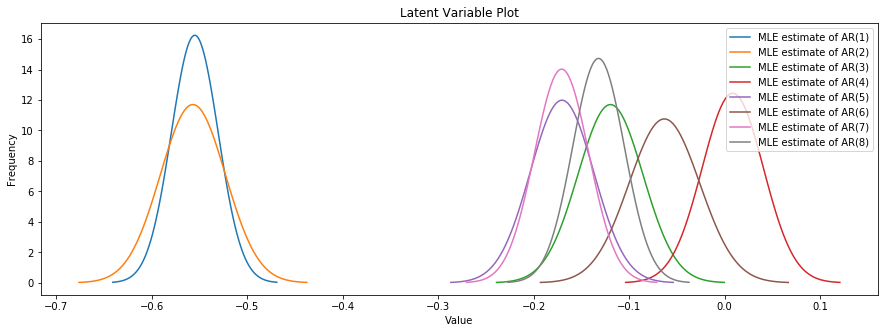

In [48]:
# plot z-scores of feature coefficients
model_arima_pf.plot_z(indices=range(1,9))

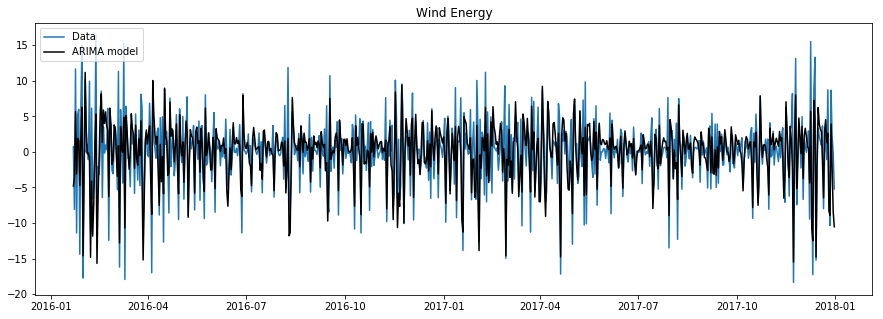

In [51]:
# pintamos el modelo contra los datos
model_arima_pf.plot_fit(figsize=(15,5))

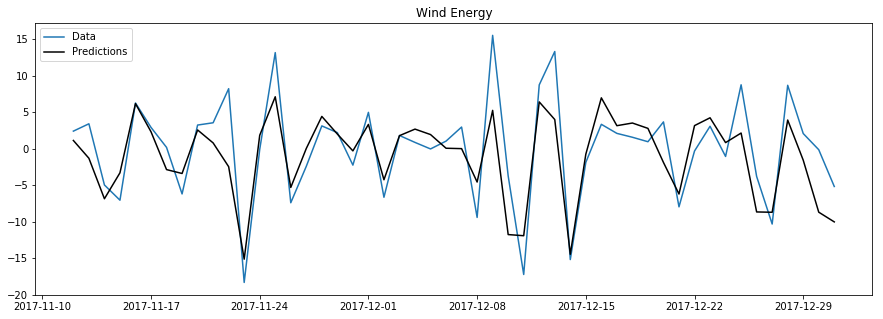

In [52]:
# pintamos prediciones
model_arima_pf.plot_predict_is(50, fit_once=False, figsize=(15,5))

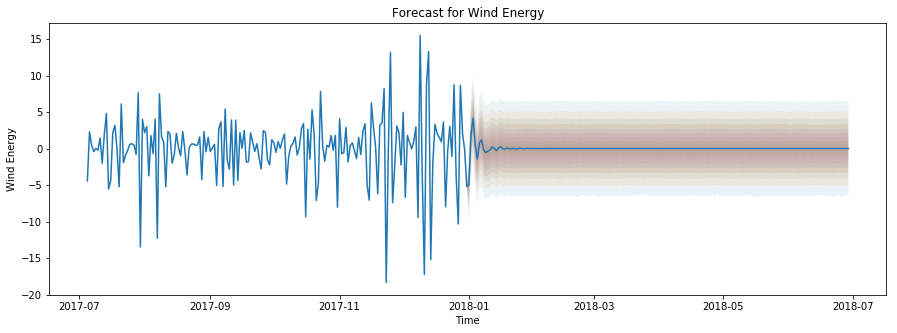

In [54]:
# pintamos el forecast
model_arima_pf.plot_predict(h=180, past_values=180, figsize=(15,5))

## Modelo SARIMA

In [33]:
# función para pintar series
def plots(data, lags=None):
    plt.figure(figsize=(15,8))
    layout = (3, 1)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [34]:
# prueba modelo sarimax
model_fit_sarima = SARIMAX(series_train, order=(1,1,0), seasonal_order=(0,1,0,12), trend=None).fit()
model_fit_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        Wind Energy   No. Observations:                  719
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -2606.030
Date:                            Sun, 21 Apr 2019   AIC                           5216.059
Time:                                    19:47:52   BIC                           5225.179
Sample:                                01-13-2016   HQIC                          5219.583
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5802      0.024    -23.701      0.000      -0.628      -0.532
sigma2        94.0727      3.810     24.690      0.000      86.605     101.540
===================================================================================
Ljung-Box (Q):                      556.98   Jarque-Bera (JB):                64.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
# probamos distintos valores del primer y segundo parámetro
for i in range(1,10):
    print('Iteración ', i, '\n')
    for j in range(0,6):
        model_sarima = SARIMAX(series_train, order=(i,j,0), seasonal_order=(0,1,0,12), trend=None).fit()
        print("SARIMA order(",i,",0,",j,"):", model_sarima.aic)
        print('\n');

Iteración  1 

SARIMA order( 1 ,0, 0 ): 4658.406503845204


SARIMA order( 1 ,0, 1 ): 5216.059402044344


SARIMA order( 1 ,0, 2 ): 5855.562842109008


SARIMA order( 1 ,0, 3 ): 6551.059386590387


SARIMA order( 1 ,0, 4 ): 7288.72164400872


SARIMA order( 1 ,0, 5 ): 8062.555470820507


Iteración  2 

SARIMA order( 2 ,0, 0 ): 4530.3552287336115


SARIMA order( 2 ,0, 1 ): 5024.312242333799


SARIMA order( 2 ,0, 2 ): 5590.863276328925


SARIMA order( 2 ,0, 3 ): 6209.307970951619


SARIMA order( 2 ,0, 4 ): 6866.303040981585


SARIMA order( 2 ,0, 5 ): 7555.864915276475


Iteración  3 

SARIMA order( 3 ,0, 0 ): 4433.72235608498


SARIMA order( 3 ,0, 1 ): 4872.667749505701


SARIMA order( 3 ,0, 2 ): 5390.655978814684


SARIMA order( 3 ,0, 3 ): 5960.134307264965


SARIMA order( 3 ,0, 4 ): 6566.186028141725


SARIMA order( 3 ,0, 5 ): 7199.205276416651


Iteración  4 

SARIMA order( 4 ,0, 0 ): 4367.483444905759


SARIMA order( 4 ,0, 1 ): 4751.6745656634275


SARIMA order( 4 ,0, 2 ): 5224.0354531223

Parece que según aumenta el valor del segundo parámetro no mejora el modelo, en cambio si al aumentar el valor del primer parámetro.

In [36]:
# ahora probamos distintos valores del primer y último parámetro
for i in range(9,10):
    for j in range(6,10):
        model_sarima = SARIMAX(series_train, order=(i,0,j), seasonal_order=(0,1,0,12), trend=None).fit()
        print("SARIMA order(",i,",0,",j,"):", model_sarima.aic)
        print('\n');

SARIMA order( 9 ,0, 6 ): 3948.1179754536042


SARIMA order( 9 ,0, 7 ): 3921.045799973854


SARIMA order( 9 ,0, 8 ): 3930.6051965988436


SARIMA order( 9 ,0, 9 ): 3871.623473794375




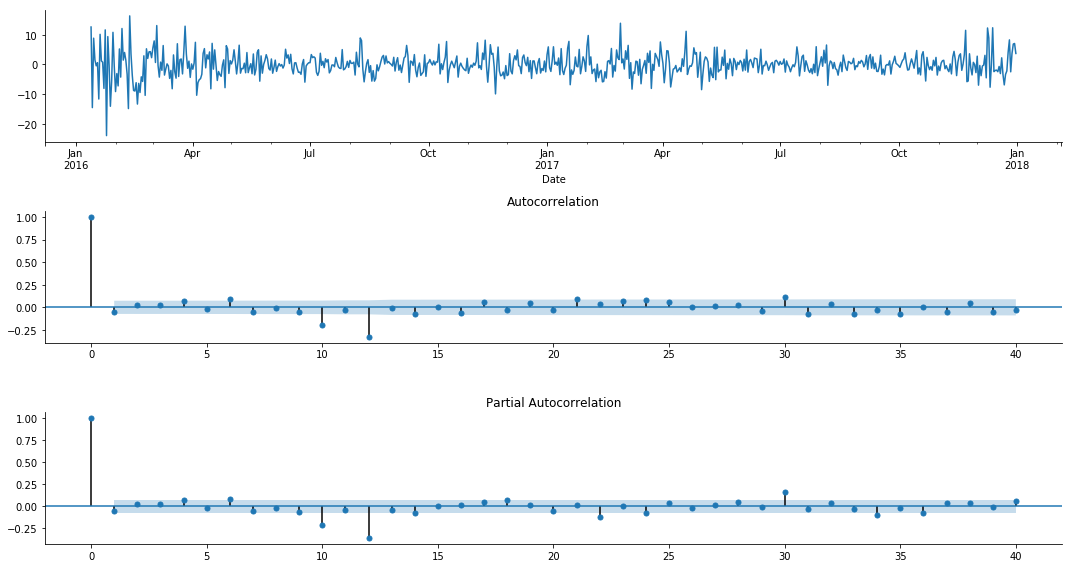

In [37]:
# pintar residuos
plots(model_sarimax.resid, lags=40);

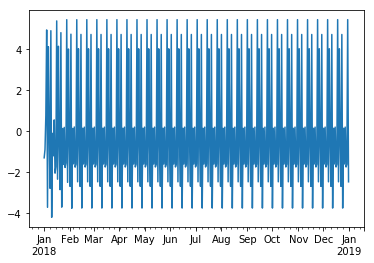

In [38]:
# plot predictions
sarima_test = model_sarimax.predict(start = '2018-01-01', end= '2018-12-31', dynamic=False)  
sarima_test.plot();

In [82]:
pred = model_sarimax.predict('2017-12-31','2018-12-31')[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(series_test,pred)))

SARIMA model MSE:41.26367007603677


<Figure size 432x288 with 0 Axes>

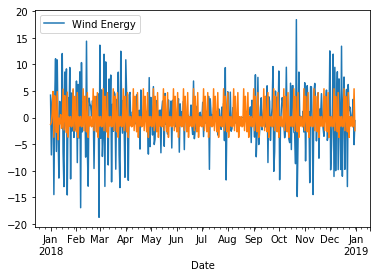

In [84]:
plt.figure();series_test.plot(); pred.plot();

## Modelos de suavizado exponencial

Posibles parámetros para instanciar el modelo **ExponentialSmoothing**:
 * *trend*: "add", "mul" o "None". Para modelar la tendencia (trend=None para modelo simple).
 * *damped*: True o False. Para indicar si queremos amortiguar la tendencia.
 * *seasonal*: "add", "mul" o "None". PAra modelar la estacionalidad (trend=None para modelo simple o doble).
 * *seasonal_periods*: periodo estacional.

Cuando entrenamos el modelo (**fit**) los parametros alpha, beta y gamma se optimizan solos por defecto.

In [43]:
# funcion summary con parámetros y errores
def mostrar_summary(model_sm):
    alpha_sm = model_sm.model.params['smoothing_level']
    betha_sm = model_sm.model.params['smoothing_slope']
    delta_sm = model_sm.model.params['smoothing_seasonal']
    mse_sm = sm.tools.eval_measures.mse(model_sm.data.endog,model_sm.fittedvalues)
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    
    print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
    print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
    print(' Smoothing parameter: delta  {0:.3f}'.format(delta_sm))
    print(' In-sample fit:')
    print(' MSE               {0:.3f}'.format(mse_sm))
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    
    return rmse_sm

In [62]:
# uso de ExponentialSmoothing con 'add'
model_add = ExponentialSmoothing(series_train, trend='add', damped=False, seasonal='add',\
                                   seasonal_periods=12).fit()

mostrar_summary(model_add);

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.211
 In-sample fit:
 MSE               31.167
 RMSE               5.583


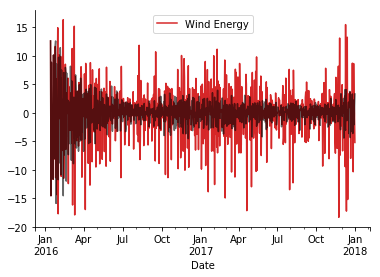

In [63]:
smoothed_add = pd.Series(model_add.fittedvalues, index=series_train.index)

series_train['2016-01':'2017-12'].plot(color='#D62728', label='Inflation')
smoothed_add.plot(color='black', label='Smoothed', alpha=0.6)

sns.despine()

In [64]:
# predecir
y_add = model_add.predict(start='2018-01-01', end='2018-12-31')
print('\n')
print(mean_squared_error(series_test['2018-01':'2018-12'], y_add))



46.849254508171896


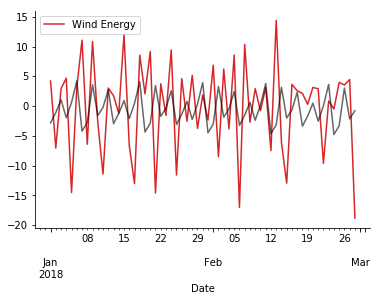

In [65]:
# pintar datos de test y las predicciones
series_test['2018-01':'2018-02'].plot(color='#D62728', label='Inflation')
y_add['2018-01':'2018-02'].plot(color='black', label='Smoothed', alpha=0.6)

sns.despine()

In [66]:
# uso de ExponentialSmoothing con damped = True
model_damped = ExponentialSmoothing(series_train, trend='add', damped=True, seasonal='add',\
                                       seasonal_periods=12).fit()

mostrar_summary(model_damped);

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.211
 In-sample fit:
 MSE               31.086
 RMSE               5.576


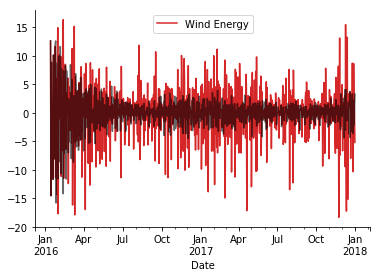

In [67]:
smoothed_damped = pd.Series(model_damped.fittedvalues, index=series_train.index)

series_train['2016-01':'2017-12'].plot(color='#D62728', label='Inflation')
smoothed_damped.plot(color='black', label='Smoothed', alpha=0.6)

sns.despine()

In [68]:
# predecir
y_damped = model_damped.predict(start='2018-01-01', end='2018-12-31')
print('\n')
print(mean_squared_error(series_test['2018-01':'2018-12'], y_damped))



40.13121026313839


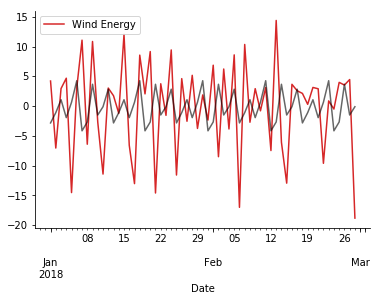

In [69]:
# pintamos los datos de test y las predicciones
series_test['2018-01':'2018-02'].plot(color='#D62728', label='Inflation')
y_damped['2018-01':'2018-02'].plot(color='black', label='Smoothed', alpha=0.6)

sns.despine()

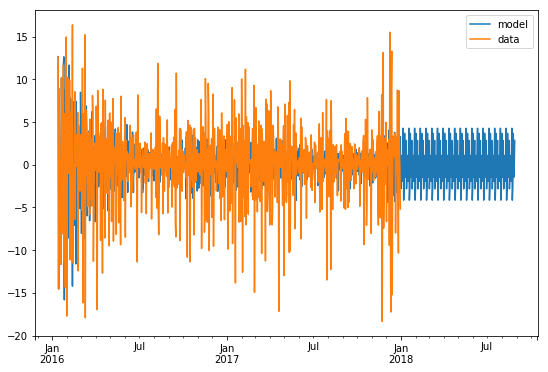

In [70]:
h=240

model = ExponentialSmoothing(series_train, trend='add', damped=True, seasonal='add', seasonal_periods=12).fit()

forecast = model.forecast(h)

plot = pd.DataFrame()
plot['model'] = pd.concat([model.fittedvalues, forecast])
plot['data'] = series_train

plot[:].plot(figsize=(9,6));